# Environment Setup

In [207]:
import os
import ast
from pathlib import Path
from typing import Dict, Any

import numpy as np
import pandas as pd

import shapely
from shapely.geometry import box
import geopandas as gpd
import rasterio

import matplotlib.pyplot as plt

import openeo
from openeo.extra.job_management import MultiBackendJobManager

# Folder Structure

In [82]:
raw_data_dir = Path("../data/raw")
proc_data_dir = Path("../data/processed")

# Parameters

In [100]:
BASELINE_PERIOD = ["2023-04-01", "2023-05-31"]
ANALYSIS_PERIOD = ["2024-04-01", "2024-05-31"]

# BASE_SPATIAL_START = {"west": 3763671.686, "south": 82036.155, "crs": "EPSG:3857", "srs": "EPSG:3857"}
BASE_SPATIAL_START = {"west": 3763671.686, "south": 82036.155, "crs": "EPSG:3857", "srs": "EPSG:3857"}
SPATIAL_WINDOW_SIZE = 10000
SPATIAL_WINDOW_GAP = 0

BANDS = ["VV"]
DELTA_TRESH = 2.0               # dB
ABS_DB_THRESH = -16.0            # dB
UNCERTAINTY_DELTA = 0.5          # +/- around delta_thresh to get min/max
EXPORT_GEOTIFFS = True   # set False if you don"t need GeoTIFFs

In [54]:
# baseline_period = ["2015-01-01", "2019-12-31"]
# analysis_period = ["2020-01-01", "2025-08-31"]
baseline_period = ["2023-04-01", "2023-05-31"]
analysis_period = ["2024-04-01", "2024-05-31"]
aoi = {  # reuse your AOI
    "type": "Polygon",
    "coordinates": [
        [
            [34.1, 1.57],
            [34.1, 0.75],
            [34.77, 0.75],
            [34.77, 1.57],
            [34.1, 1.57],
        ]
    ],
}


# Functions

In [105]:
def split_list(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [76]:
def create_spatial_extent(offset_x: int, offset_y: int, base_extent: Dict[str, Any] = BASE_SPATIAL_START) -> Dict[str, Any]:
    """Create a spatial extent dictionary based on an offset for 10km by 10km windows."""
    return {
        "west": base_extent["west"] + offset_x * (SPATIAL_WINDOW_SIZE + SPATIAL_WINDOW_GAP),
        "south": base_extent["south"] + offset_y * (SPATIAL_WINDOW_SIZE + SPATIAL_WINDOW_GAP),
        "east": base_extent["west"] + (offset_x + 1) * SPATIAL_WINDOW_SIZE + offset_x * SPATIAL_WINDOW_GAP,
        "north": base_extent["south"] + (offset_y + 1) * SPATIAL_WINDOW_SIZE + offset_y * SPATIAL_WINDOW_GAP,
        "crs": base_extent["crs"],
        "srs": base_extent["srs"]
    }

In [223]:
def prepare_jobs_db(max_offset:int, date_chunk_size = 10) -> pd.DataFrame:
    """Prepare a database using pandas, containing job configurations for benchmarking."""
    dates = pd.date_range(start = ANALYSIS_PERIOD[0], end = ANALYSIS_PERIOD[1]).astype(str).tolist()
    dates_chunk = list(split_list(dates, n = date_chunk_size))
    jobs = []

    # Create combinations for the spatial grid
    for offset_x in range(max_offset):
        for offset_y in range(max_offset):
            for chunk in dates_chunk:
                spatial_extent = create_spatial_extent(offset_x, offset_y)
                polygon_extent = box(spatial_extent["west"], spatial_extent["south"], spatial_extent["east"], spatial_extent["north"])
                if shapely.intersects(sf_uga, polygon_extent):
                    jobs.append({
                        "spatial_extent": create_spatial_extent(offset_x, offset_y),
                        "temporal_extent": [chunk[0], chunk[-1]]
                    })
                else: 
                    pass
    return pd.DataFrame(jobs)

In [235]:
def visualize_spatial_extents(jobs_database: pd.DataFrame, shape: gpd.GeoDataFrame):
    """Visualize spatial extents from the given DataFrame and overlay images for finished jobs."""
    _, ax = plt.subplots(figsize=(6, 6))

    jobs_database_geom = jobs_database["spatial_extent"].value_counts().reset_index()
    
    # Create a GeoDataFrame for spatial extents
    geometries = []
    for _, row in jobs_database_geom.iterrows():
        extent = row["spatial_extent"]
        rectangle = box(extent["west"], extent["south"], extent["east"], extent["north"])
        geometries.append(rectangle)
    
    gdf = gpd.GeoDataFrame(geometry=geometries)
    
    # Plot the spatial extents
    shape.plot(ax=ax, edgecolor = "black", facecolor = "none")
    gdf.plot(ax=ax, facecolor="none", edgecolor="blue")
    
    plt.xlabel("Easting (meters)")
    plt.ylabel("Northing (meters)")
    plt.title("Spatial Extents Visualization")
    plt.grid(True)
    plt.show()

In [237]:
def start_job(row: pd.Series, connection: openeo.Connection, **kwargs) -> openeo.BatchJob:
    """Start a new job using the specified row out of the jobs data base and connection."""
    
    # Get the variable parameters from the dataframe
    print(row)
    spatial_extent = row["spatial_extent"]
    temporal_extent = row["temporal_extent"]

    # Baseline

    baseline = (
        connection.load_collection(
            "SENTINEL1_GRD",
            temporal_extent=baseline_period,
            spatial_extent=spatial_extent,
            bands=bands,
        )
        .sar_backscatter(coefficient="sigma0-ellipsoid")
    )

    baseline_db = baseline.apply(process=lambda data: 10 * openeo.processes.log(data, base=10))
    baseline_median = baseline_db.reduce_dimension(dimension="t", reducer=lambda data: openeo.processes.median(data))
    baseline_median = baseline_median.rename_labels(dimension="bands", target=["median"])
    baseline_std = baseline_db.reduce_dimension(dimension="t", reducer=lambda data: openeo.processes.sd(data))
    baseline_std = baseline_median.rename_labels(dimension="bands", target=["std"])

    # Current data
    
    bck = (
        connection.load_collection(
            "SENTINEL1_GRD",
            temporal_extent=temporal_extent,
            spatial_extent=spatial_extent,
            bands=bands,
        )
        .sar_backscatter(coefficient="sigma0-ellipsoid")
    )
    
    bck_db = bck.apply(process=lambda data: 10 * openeo.processes.log(data, base=10))
    bck_db = bck_db.rename_labels(dimension="bands", target=["current"])
    bck_db = bck_db.merge_cubes(baseline_median).merge_cubes(baseline_std)
    # flood_data = bck_db.band("current") < (bck_db.band("median") - bck_db.band("std"))

    bck_db.save_result(format = "GTiff")
    # flood_data.save_result(format = "GTiff")
    
    return bck_db.create_job(
        title="Daily Flood"
    )

# Start database connections

In [55]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


# Import data

In [219]:
sf_uga_adm = (
    gpd.read_file(
        raw_data_dir / "geographies/uganda_herbert/uganda_districts.shp"
    )
    .rename(columns = str.lower)
    .assign(
        district = lambda x: x["district"].case_when([
            (x["district"] == "SSEMBABULE", "Sembabule"),
            (x["district"] == "KASSNDA", "Kassanda"),
            (x["district"] == "MADI OKOLLO", "Madi-Okollo"),
            (x["district"] == "NAMUTUNMBA", "Namutumba")
        ]).str.title()
    )
    .to_crs(3857)
    [[
        "district",
        "geometry"
    ]]
)

In [230]:
sf_uga = sf_uga_adm.dissolve().geometry[0]

# Prepare job database

In [231]:
jobs_database = prepare_jobs_db(max_offset = 17, date_chunk_size=10)

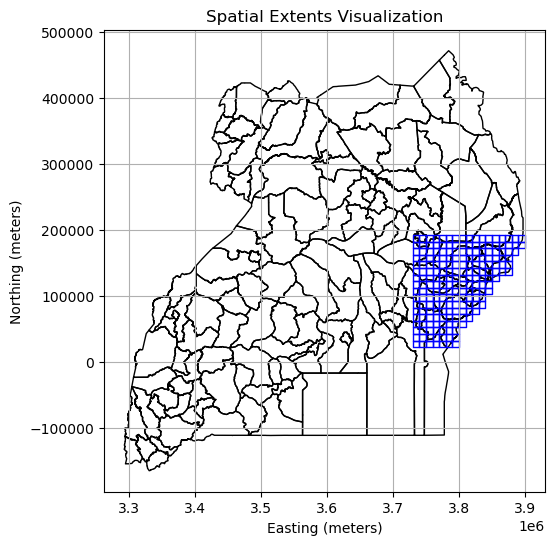

In [236]:
visualize_spatial_extents(jobs_database, sf_uga_adm)

# Setup Job Manager

In [238]:
# Generate a unique name for the tracker
job_tracker = str((proc_data_dir / "sentinel_1" / "uganda_floods_job_tracker.csv").resolve())
try: 
    os.remove(job_tracker)
except OSError:
    pass
# Initiate MultiBackendJobManager 
manager = MultiBackendJobManager()  
manager.add_backend("cdse", connection=connection, parallel_jobs=4)

# Run the jobs
manager.run_jobs(df=jobs_database, start_job=start_job, job_db=job_tracker)

spatial_extent        {'west': 3729202.94, 'south': 22263.94, 'east'...
temporal_extent                                [2024-04-01, 2024-04-10]
id                                                                 None
backend_name                                                       cdse
status                                                      not_started
start_time                                                         None
running_start_time                                                 None
cpu                                                                None
memory                                                             None
duration                                                           None
costs                                                              None
Name: 0, dtype: object
spatial_extent        {'west': 3729202.94, 'south': 22263.94, 'east'...
temporal_extent                                [2024-04-11, 2024-04-20]
id                                       

No assets found in job result metadata.


spatial_extent        {'west': 3729202.94, 'south': 32263.94, 'east'...
temporal_extent                                [2024-04-11, 2024-04-20]
id                                                                 None
backend_name                                                       cdse
status                                                      not_started
start_time                                                         None
running_start_time                                                 None
cpu                                                                None
memory                                                             None
duration                                                           None
costs                                                              None
Name: 8, dtype: object
spatial_extent        {'west': 3729202.94, 'south': 32263.94, 'east'...
temporal_extent                                [2024-04-21, 2024-04-30]
id                                       

No assets found in job result metadata.


spatial_extent        {'west': 3729202.94, 'south': 32263.94, 'east'...
temporal_extent                                [2024-05-21, 2024-05-30]
id                                                                 None
backend_name                                                       cdse
status                                                      not_started
start_time                                                         None
running_start_time                                                 None
cpu                                                                None
memory                                                             None
duration                                                           None
costs                                                              None
Name: 12, dtype: object
spatial_extent        {'west': 3729202.94, 'south': 32263.94, 'east'...
temporal_extent                                [2024-05-31, 2024-05-31]
id                                      

No assets found in job result metadata.


spatial_extent        {'west': 3729202.94, 'south': 42263.94, 'east'...
temporal_extent                                [2024-04-21, 2024-04-30]
id                                                                 None
backend_name                                                       cdse
status                                                      not_started
start_time                                                         None
running_start_time                                                 None
cpu                                                                None
memory                                                             None
duration                                                           None
costs                                                              None
Name: 16, dtype: object
spatial_extent        {'west': 3729202.94, 'south': 42263.94, 'east'...
temporal_extent                                [2024-05-01, 2024-05-10]
id                                      

No assets found in job result metadata.


spatial_extent        {'west': 3729202.94, 'south': 42263.94, 'east'...
temporal_extent                                [2024-05-11, 2024-05-20]
id                                                                 None
backend_name                                                       cdse
status                                                      not_started
start_time                                                         None
running_start_time                                                 None
cpu                                                                None
memory                                                             None
duration                                                           None
costs                                                              None
Name: 18, dtype: object
spatial_extent        {'west': 3729202.94, 'south': 42263.94, 'east'...
temporal_extent                                [2024-05-21, 2024-05-30]
id                                      

No assets found in job result metadata.


spatial_extent        {'west': 3729202.94, 'south': 52263.94, 'east'...
temporal_extent                                [2024-04-11, 2024-04-20]
id                                                                 None
backend_name                                                       cdse
status                                                      not_started
start_time                                                         None
running_start_time                                                 None
cpu                                                                None
memory                                                             None
duration                                                           None
costs                                                              None
Name: 22, dtype: object
spatial_extent        {'west': 3729202.94, 'south': 52263.94, 'east'...
temporal_extent                                [2024-04-21, 2024-04-30]
id                                      

No assets found in job result metadata.


spatial_extent        {'west': 3729202.94, 'south': 52263.94, 'east'...
temporal_extent                                [2024-05-21, 2024-05-30]
id                                                                 None
backend_name                                                       cdse
status                                                      not_started
start_time                                                         None
running_start_time                                                 None
cpu                                                                None
memory                                                             None
duration                                                           None
costs                                                              None
Name: 26, dtype: object
spatial_extent        {'west': 3729202.94, 'south': 52263.94, 'east'...
temporal_extent                                [2024-05-31, 2024-05-31]
id                                      

No assets found in job result metadata.


spatial_extent        {'west': 3729202.94, 'south': 62263.94, 'east'...
temporal_extent                                [2024-04-21, 2024-04-30]
id                                                                 None
backend_name                                                       cdse
status                                                      not_started
start_time                                                         None
running_start_time                                                 None
cpu                                                                None
memory                                                             None
duration                                                           None
costs                                                              None
Name: 30, dtype: object
spatial_extent        {'west': 3729202.94, 'south': 62263.94, 'east'...
temporal_extent                                [2024-05-01, 2024-05-10]
id                                      

No assets found in job result metadata.


spatial_extent        {'west': 3729202.94, 'south': 62263.94, 'east'...
temporal_extent                                [2024-05-11, 2024-05-20]
id                                                                 None
backend_name                                                       cdse
status                                                      not_started
start_time                                                         None
running_start_time                                                 None
cpu                                                                None
memory                                                             None
duration                                                           None
costs                                                              None
Name: 32, dtype: object
spatial_extent        {'west': 3729202.94, 'south': 62263.94, 'east'...
temporal_extent                                [2024-05-21, 2024-05-30]
id                                      

No assets found in job result metadata.


spatial_extent        {'west': 3729202.94, 'south': 72263.94, 'east'...
temporal_extent                                [2024-04-11, 2024-04-20]
id                                                                 None
backend_name                                                       cdse
status                                                      not_started
start_time                                                         None
running_start_time                                                 None
cpu                                                                None
memory                                                             None
duration                                                           None
costs                                                              None
Name: 36, dtype: object


Failed to obtain new access token (grant 'refresh_token'): OidcException('Failed to retrieve access token at \'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token\': ConnectionError(ProtocolError(\'Connection aborted.\', OSError(49, "Can\'t assign requested address")))').
Failed to proactively refresh bearer token


spatial_extent        {'west': 3729202.94, 'south': 72263.94, 'east'...
temporal_extent                                [2024-04-21, 2024-04-30]
id                                                                 None
backend_name                                                       cdse
status                                                      not_started
start_time                                                         None
running_start_time                                                 None
cpu                                                                None
memory                                                             None
duration                                                           None
costs                                                              None
Name: 37, dtype: object
spatial_extent        {'west': 3729202.94, 'south': 72263.94, 'east'...
temporal_extent                                [2024-05-01, 2024-05-10]
id                                      

Failed to start job 'j-2512101836214d00bc26e80d42bf9256': OpenEoApiError('[401] TokenInvalid: Authorization token has expired or is invalid. Please authenticate again.')
Failed to start job 'j-25121019423441668fc3ff33453ce466': OpenEoApiError('[401] TokenInvalid: Authorization token has expired or is invalid. Please authenticate again.')
Failed to start job 'j-25121019291645dc8f9fd715e26f3bf9': OpenEoApiError('[401] TokenInvalid: Authorization token has expired or is invalid. Please authenticate again.')
Failed to obtain new access token (grant 'refresh_token'): OidcException('Failed to retrieve access token at \'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token\': ConnectionError(ProtocolError(\'Connection aborted.\', OSError(49, "Can\'t assign requested address")))'). Reason: OIDC access token expired (403 TokenInvalid).


OpenEoApiError: [403] TokenInvalid: Authorization token has expired or is invalid. Please authenticate again. (ref: r-25121108251141aabee0e036bf28c37c)

In [64]:
flood_data.execute_batch(title="Flood Data", outputfile="flood_data.nc")

0:00:00 Job 'j-251209170510486587eed45bf5c27900': send 'start'
0:00:16 Job 'j-251209170510486587eed45bf5c27900': created (progress 0%)
0:00:21 Job 'j-251209170510486587eed45bf5c27900': created (progress 0%)
0:00:27 Job 'j-251209170510486587eed45bf5c27900': created (progress 0%)
0:00:35 Job 'j-251209170510486587eed45bf5c27900': created (progress 0%)
0:00:45 Job 'j-251209170510486587eed45bf5c27900': created (progress 0%)
0:00:58 Job 'j-251209170510486587eed45bf5c27900': created (progress 0%)
0:01:13 Job 'j-251209170510486587eed45bf5c27900': running (progress N/A)
0:01:32 Job 'j-251209170510486587eed45bf5c27900': running (progress N/A)
0:01:56 Job 'j-251209170510486587eed45bf5c27900': running (progress N/A)
0:02:26 Job 'j-251209170510486587eed45bf5c27900': running (progress N/A)
0:03:04 Job 'j-251209170510486587eed45bf5c27900': running (progress N/A)
0:03:50 Job 'j-251209170510486587eed45bf5c27900': running (progress N/A)
0:04:49 Job 'j-251209170510486587eed45bf5c27900': running (progress

KeyboardInterrupt: 